In [1]:
import tensorflow as tf
import pandas as pd
import os

2024-05-26 21:18:52.061192: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 21:18:52.061318: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 21:18:52.199915: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def parse_function(proto):
    feature_description = {
    'x': tf.io.FixedLenFeature([556], tf.float32),
    'targets': tf.io.FixedLenFeature([368], tf.float32)
    }     
    parsed_features = tf.io.parse_single_example(proto, feature_description)
    features = parsed_features['x']
    targets = parsed_features['targets']
    return features, targets

In [3]:
N_elements_per_tfrecord = 100000
file_path_data = "/kaggle/input/leap-train-tfrecords/"
train_files = [os.path.join(file_path_data, "train_%.3d.tfrec" % i) for i in range(100)]
valid_files = [os.path.join(file_path_data, "train_%.3d.tfrec" % i) for i in range(100, 101)]




In [4]:
BATCH_SIZE=4024
def build_dataset(filepaths):
    return tf.data.TFRecordDataset(filepaths).shuffle(100).map(
        map_func=parse_function,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(
        batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


train_set = build_dataset(train_files)
valid_set = build_dataset(valid_files)



In [5]:
# Create normalization layer and adapt it to the training data
normalization_layer = tf.keras.layers.Normalization()
sample_data = train_set.map(lambda x, y: x).take(40)  # Take a sample of 20 batches to adapt the normalization layer
normalization_layer.adapt(sample_data)

# Define the model
model = tf.keras.Sequential([
    normalization_layer,
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512,activation="relu"),
    tf.keras.layers.Dense(368)  # Adjust the output shape as needed
])


In [6]:
# Learning rate scheduler with warmup and cosine decay
import numpy as np

# Learning rate scheduler with exponential decay
initial_learning_rate = 1e-3
decay_steps = 100000  # Number of steps before the learning rate is decayed
decay_rate = 0.96  # The rate at which the learning rate decays

lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True  # If True, decay the learning rate at discrete intervals
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)


In [7]:
steps_per_epoch = int(np.ceil(len(train_files) * 100000 / BATCH_SIZE))

# Fit the model
history = model.fit(
    train_set,
    validation_data=valid_set,
    epochs=10,  # Total number of epochs
    steps_per_epoch=steps_per_epoch,
    validation_steps=steps_per_epoch // 10  # Adjust validation steps as needed
)

Epoch 1/10
   6/2486 ━━━━━━━━━━━━━━━━━━━━ 1:11 29ms/step - loss: 659.8342 - mean_absolute_error: 2.4289

I0000 00:00:1716758355.794094      68 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716758355.810990      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2486/2486 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 31.8128 - mean_absolute_error: 0.7054

W0000 00:00:1716758947.095210      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716758947.838164      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2486/2486 ━━━━━━━━━━━━━━━━━━━━ 601s 240ms/step - loss: 31.8041 - mean_absolute_error: 0.7053 - val_loss: 5.3387 - val_mean_absolute_error: 0.5061
Epoch 2/10


W0000 00:00:1716758953.410390      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2486/2486 ━━━━━━━━━━━━━━━━━━━━ 2s 640us/step - loss: 0.0000e+00 - mean_absolute_error: 0.0000e+00 - val_loss: 5.3387 - val_mean_absolute_error: 0.5061
Epoch 3/10
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 485s 195ms/step - loss: 6.9382 - mean_absolute_error: 0.4035 - val_loss: 5.7791 - val_mean_absolute_error: 0.3755
Epoch 4/10
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0000e+00 - mean_absolute_error: 0.0000e+00 - val_loss: 5.7791 - val_mean_absolute_error: 0.3755
Epoch 5/10
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 476s 192ms/step - loss: 5.5038 - mean_absolute_error: 0.3346 - val_loss: 4.8386 - val_mean_absolute_error: 0.2541
Epoch 6/10
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0000e+00 - mean_absolute_error: 0.0000e+00 - val_loss: 4.8386 - val_mean_absolute_error: 0.2541
Epoch 7/10
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 478s 192ms/step - loss: 4.8839 - mean_absolute_error: 0.2972 - val_loss: 4.1391 - val_mean_absolute_error: 0.2160
Epoch 8/10
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 2s 612us/step - los

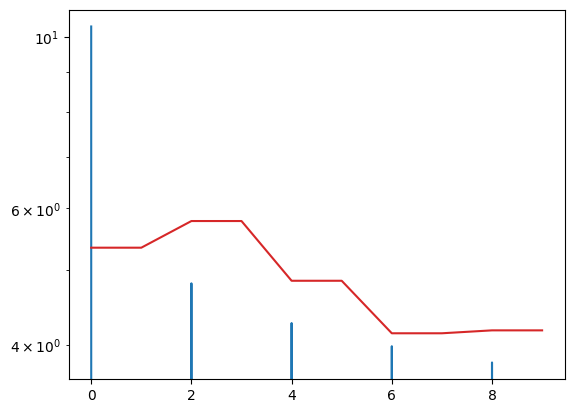

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], color='tab:blue')
plt.plot(history.history['val_loss'], color='tab:red')
plt.yscale('log')